# Bibliotecas

In [57]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from itertools import permutations
from itertools import combinations
import gc

# Importação do DataSet

In [2]:
dataset = '../data/Base VoceQPad.xlsx'
base = pd.read_excel(dataset)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Tratamento dos Dados

In [3]:
# TRATAMENTO DO DATAFRAME BASE

# mudando de objeto para data
base['data_compra'] = pd.to_datetime(base['data_compra'])
base['usuário_data-cadastro'] = pd.to_datetime(base['usuário_data-cadastro'])

# tipo de dados mudado de objeto para categoria de forma que ocupe menos espaço na memória
base['modalidade_compra'] = base['modalidade_compra'].astype('category')
base['plataforma-compra'] = base['plataforma-compra'].astype('category')

# retirando os pedidos com 100% de desconto, como mencionado an dúvida 3 do projeto
base = base.loc[(base['valor-pedido'] + base['valor-desconto'] != 0)]
base = base.loc[(base['valor-pedido'] + base['valor-desconto']) > 0]

# alteração de tipos de colunas
base['qtde_itens'] = base['qtde_itens'].astype('int')
base['dist-pedido'] = pd.to_numeric(base['dist-pedido'], errors='coerce')
base['dist-pedido'] = base['dist-pedido'].fillna(0)

# limitação de casas decimais
base['dist-pedido'] = base['dist-pedido'].round(3)

# Tirando possíveis testes, como mencionado na dúvida 4 do projeto
base = base.loc[base['dist-pedido'] < 14.001]

base['dias-desde-compra-anterior'].replace('-', '0', inplace=True)
base['dias-desde-compra-anterior'] = base['dias-desde-compra-anterior'].astype(int)

base['itens_compra'] = base['itens_compra'].apply(lambda x: x.split(' | '))
base = base.explode('itens_compra')
base = base.reset_index(drop=True)
base['quantidade'] = base['itens_compra'].apply(lambda x: x[-1])
base['itens_compra'] = base['itens_compra'].str.replace(r'\s*x\d+', '')

base = base.rename({'id_usuário': 'user_id', 'itens_compra': 'item_id', 'data_compra': 'Date'}, axis = 1)

In [4]:
user_ids = base['user_id'].unique()
pd.DataFrame(user_ids, columns= ['user_id'])

,user_id
0,452249
1,660888
2,651393
3,660894
4,486041
...,...
87443,1062780
87444,1062782
87445,1062784
87446,1062792


In [5]:
def base_selection():
    print(base['id_aplicativo'].unique())
    # app_input = input("Digite o aplicativo escolhido: ")
    app_input = 37
    
    try:
        app = int(app_input)
        
        if app not in base['id_aplicativo'].unique():
            print("Escolha inválida. Por favor, digite um aplicativo válido.")
            return None  
    except ValueError:
        print("Entrada inválida. Por favor, digite um número inteiro válido.")
        return None  
    
    df = base.loc[base['id_aplicativo'] == app]
    df = df[['id_aplicativo', 'id_compra', 'Date', 'user_id', 'quantidade', 'item_id']]

    return df

def base_tratatives(df):
    NumProduto = pd.DataFrame(df.groupby(['user_id'])['item_id'].value_counts())
    NumProduto = NumProduto.rename(columns={'item_id': 'FreqItem'})
    NumProduto = NumProduto.reset_index(level=['user_id', 'item_id'])
    totalFreq = NumProduto.groupby(['user_id'])[['FreqItem']].sum()
    totalFreq = totalFreq.reset_index().rename({'FreqItem': 'TotalPeriodo'}, axis = 1)

    NumProduto = NumProduto.merge(totalFreq, on = 'user_id', how = 'left')
    NumProduto['FrequenciaItem'] = NumProduto['FreqItem']/NumProduto['TotalPeriodo']
    NumProduto = NumProduto.query('TotalPeriodo >= 3')
    FreqCompra = NumProduto[['user_id', 'item_id', 'FrequenciaItem']]
    
    dfProduto = df.copy()
    dfProduto = dfProduto.merge(FreqCompra, on = ['user_id', 'item_id'], how = 'left')
    dfProduto = dfProduto.dropna()
    
    df_covisitation = dfProduto[['user_id', 'item_id', 'FrequenciaItem']].rename({'FrequenciaItem': 'rating'}, axis = 1)
    df_covisitation = df_covisitation.query('rating >= 0.1').reset_index(drop=True)
    
    user_list = df_covisitation['user_id'].unique()
    
    return NumProduto, totalFreq, FreqCompra, dfProduto, df_covisitation, user_list

# Modelo TOP N

**Top N consumidos**: os N itens mais consumidos pelos usuários no período

In [6]:
def recommend_top_n_consumptions(ratings:pd.DataFrame, n:int) -> pd.DataFrame:

    recommendations = (
        ratings
        .groupby('item_id')
        .count()['user_id']
        .reset_index()
        .rename({'user_id': 'score'}, axis=1)
        .sort_values(by='score', ascending=False)
    )

    return recommendations.head(n)

def recommendation_top(df_seed, df_top_consumptions): 
  df_top_recommendations = pd.DataFrame()
  for user in df_seed['user_id']:
    item_ids = df_top_consumptions['item_id']
    df_temp = pd.DataFrame()
    df_temp['recommendation'] = item_ids
    df_temp['user_id'] = user
    df_top_recommendations = df_top_recommendations.append(df_temp)
  return df_top_recommendations

# Modelo Covisitation

Neste notebook iremos explorar a recomendação de itens a partir de co-visitação de itens. Este tipo de recomendação é utilizada em ofertas como "_Clientes que compraram X também compraram Y_".

Para criar o algoritmo utilizaremos a biblioteca [NetworkX](https://networkx.org/) que possibilita a criação, manipulação e estudos de estruturas em grafos.

Será utilizado para os usuários que já compraram na plataforma.

Os vizinhos de um nó do tipo `item` são os são todos os usuários que o salvaram enquanto os vizinhos de um nó do tipo `usuário` são todos os itens salvos por este usuário.

Desta forma, se quisermos a construção "_Quem viu X também viu Y_" podemos seguir o caminho:

1. Escolha do item-alvo
2. Obtenção dos vizinhos do item-alvo (usuários que o salvaram)
3. Vizinhos dos usuários que viram o item-alvo

In [7]:
#Montagem dos Grafos

def grafos_trained(df_train_covisitation):
    G_train = nx.Graph()
    G_train.add_nodes_from(df_train_covisitation['item_id'].unique(), node_type='item')
    G_train.add_nodes_from(df_train_covisitation['user_id'].unique(), node_type='user')
    G_train.add_weighted_edges_from(df_train_covisitation[['user_id', 'item_id', 'rating']].values)
    
    return G_train

Por fim, podemos juntar a lógica na função `recommend_neighbor_items()` que recebe como parâmetros:
- `G`: o grafo de itens e usuários
- `target_id`: o ID do item-alvo
- `n`: o número de itens a serem recomendados

**Nota**: uma validação inicial é feita para validar se o ID do nó é do tipo `item`

In [8]:
# Gerar Recomendações
def recommend_neighbor_items_trained(G_train:nx.Graph, target_id, n=10):
    # Validando tipo do nó
    node_type = nx.get_node_attributes(G_train, 'node_type')[target_id]
    if node_type != 'item':
        raise ValueError('Node is not of item type.')

    # Analisando consumo dos usuários vizinhos
    neighbor_consumed_items = []
    for user_id in G_train.neighbors(target_id):
        user_consumed_items = G_train.neighbors(user_id)
        neighbor_consumed_items +=list(user_consumed_items)

    # Contabilizando itens consumidos pelos vizinhos
    consumed_items_count = Counter(neighbor_consumed_items)

    # Criando dataframe
    df_neighbors = pd.DataFrame(zip(consumed_items_count.keys(), consumed_items_count.values()))
    df_neighbors.columns = ['item_id', 'score']
    df_neighbors = df_neighbors.sort_values(by='score', ascending=False).set_index('item_id')
    
    return df_neighbors.head(n)

## Divisão em Treino e Teste

In [9]:
### Versão final

def test_df(df_covisitation, user_list):
    df_test = pd.DataFrame()
    for user in user_list:
        df_seed = df_covisitation.query('user_id == @user').iloc[-1][['user_id', 'item_id', 'rating']]
        df_test = df_test.append(df_seed)
    return df_test

## Encontrar o Seed

Seed é o item que será utilizado para fazer as recomendações (neste caso, é o último item que o usuário comprou, na base de treino)

In [10]:
def item_seed(df_covisitation, user_list):
    item_seed_df = pd.DataFrame()
    for user in user_list:
        user_data = df_covisitation[df_covisitation['user_id'] == user]
        if not user_data.empty:
            last_row = user_data.iloc[-1][['user_id', 'item_id', 'rating']]
            item_seed_df = item_seed_df.append(last_row)
    return item_seed_df

## Recomendação para o Item Seed

In [14]:
def recommendation_seed(df_seed, G_train):
    df_covisitation_recommendations = pd.DataFrame()
    for user in df_seed['user_id']:
        item_seed = df_seed.query('user_id == @user')['item_id'].values[0]
        item_ids = recommend_neighbor_items_trained(G_train, item_seed, n=10).index
        df_temp = pd.DataFrame()
        df_temp['recommendation'] = item_ids
        df_temp['user_id'] = user
        df_temp['item_seed'] = item_seed
        df_covisitation_recommendations = df_covisitation_recommendations.append(df_temp)
        
    return df_covisitation_recommendations

## Explosion (para métricas)

In [12]:
def explosion(df_covisitation_recommendation, df_test_covisitation):
    df_covi_recommendation = df_covisitation_recommendation.groupby(['user_id', 'item_seed']).agg({'recommendation': list}).reset_index(drop=False)
    df_covisitation_recommendation = df_covi_recommendation.merge(df_test_covisitation[['user_id', 'item_id']], on = 'user_id', how = 'left')
    
    explode = df_covisitation_recommendation.explode('recommendation').reset_index(drop = True)
    explode['true'] = 0
    for index in explode.index:
          if explode['recommendation'][index] == explode['item_id'][index]:
                 explode['true'][index] = 1
    
    df_covisitation_recommendation = explode.groupby(['user_id', 'item_seed', 'item_id']).agg({'recommendation': list, 'true': sum}).reset_index(drop=False)
    return df_covisitation_recommendation

## Teste para um app (37)

In [14]:
df = base_selection()

[ 37   5   4  80  82  29   6  62  72  50  61  21  33  89   9  73  15  49
  57  45  69  94  68  92  78  93  39  34   8  90  66  11  18  74  99  17
  36  47  59  75  87  46  98 104 106  31 107  96 108 112 114 116 120 122
 118 121 119]


In [15]:
NumProduto, totalFreq, FreqCompra, dfProduto, df_covisitation, user_list = base_tratatives(df)

In [16]:
df_test_covisitation = test_df(df_covisitation, user_list)
df_train_covisitation = df_covisitation.drop(df_test_covisitation.index ,axis = 0)

In [17]:
item_seed_df = item_seed(df_train_covisitation, user_list)

In [18]:
user_list = df_train_covisitation['user_id'].unique()
df_seed = item_seed(df_train_covisitation, user_list)

In [19]:
n_users = df_train_covisitation['user_id'].nunique()
n_items = df_train_covisitation['item_id'].nunique()
n_ratings = df_train_covisitation[['user_id', 'item_id']].drop_duplicates().shape[0]

print (f'#Usuários: {n_users}')
print (f'#Itens: {n_items}')
print (f'#Avaliações: {n_ratings}')

#Usuários: 14710
#Itens: 99
#Avaliações: 46239


In [23]:
G_train = grafos_trained(df_train_covisitation)

In [27]:
df_covisitation_recommendation = recommendation_seed(df_seed, G_train)

In [29]:
df_covisitation_recommendation = explosion(df_covisitation_recommendation, df_test_covisitation)

In [30]:
assertividade = df_covisitation_recommendation['true'].sum()/df_covisitation_recommendation['true'].count()
print(f'A Assertividade do modelo é de {assertividade*100:.2f} %')

A Assertividade do modelo é de 65.53 %


In [31]:
flat_recommendations = [item for sublist in df_covisitation_recommendation['recommendation'] for item in sublist]

# Calculate the coverage
cobertura = len(set(flat_recommendations)) / len(pd.DataFrame(dfProduto['item_id'].unique()))
print(f'A Cobertura do modelo é de {cobertura*100:.2f} % do catálogo')

A Cobertura do modelo é de 81.65 % do catálogo


# Modelo Combinação 2 a 2

In [58]:
def create_pairs(items):
    pairs = pd.DataFrame(combinations(items, 2), columns=['item_1', 'item_2'])
    return pairs

In [249]:
# Adquirir combinações 2-a-2 de itens por usuário

def combinacao(df):
    item_combinations = (
        df
        .groupby('user_id').item_id
        .apply(create_pairs)
        .reset_index(drop=True)
    )
    # Calcular quantidade que itens aparecem juntos e estruturar output
    item_combinations = item_combinations.groupby(['item_1','item_2']).size().to_frame('count').sort_values('count', ascending=False).reset_index()

    return item_combinations

def get_recommendation_by_bought_together(item_combinations, item, n=10):
    item_bool = item_combinations.item_1.eq(item)
    if item_bool.any():
        recommendation_df = item_combinations[item_bool].set_index('item_1').head(n)
        return recommendation_df.rename_axis('target_item').rename(columns={'item_2':'item_recommendation'})
    else:
       return pd.DataFrame()
       
       

def recommendation_permutation(df_seed, item_combinations): 
  df_permutation_recommendations = pd.DataFrame()
  for user in df_seed['user_id']:
    item_seed = df_seed.query('user_id == @user')['item_id'].values[0]
    item_ids = get_recommendation_by_bought_together(item_combinations, item_seed, n=10)
    if item_ids.shape[0] != 0:
      item_ids = item_ids.set_index('item_recommendation').index
      df_temp = pd.DataFrame()
      df_temp['recommendation'] = get_recommendation_by_bought_together(item_combinations, item_seed, n=10)['item_recommendation'].tolist()
      df_temp['user_id'] = user
      df_temp['item_seed'] = item_seed
      df_permutation_recommendations = df_permutation_recommendations.append(df_temp)
  return df_permutation_recommendations

In [236]:
df_covisitation.shape[0] ==0 

False

In [231]:
item_bool.any()

False

In [ ]:
def recommendation_seed(df_seed, G_train):
    df_covisitation_recommendations = pd.DataFrame()
    for user in df_seed['user_id']:
        item_seed = df_seed.query('user_id == @user')['item_id'].values[0]
        item_ids = recommend_neighbor_items_trained(G_train, item_seed, n=10).index
        df_temp = pd.DataFrame()
        df_temp['recommendation'] = item_ids
        df_temp['user_id'] = user
        df_temp['item_seed'] = item_seed
        df_covisitation_recommendations = df_covisitation_recommendations.append(df_temp)
        
    return df_covisitation_recommendations

# Métricas

## Covisitation

In [37]:
df_covisitation_recommendation = pd.DataFrame()
app = base['id_aplicativo'].unique()
app.sort()

# Rodar o modelo para todos os app do dataset
for i in app:
    if base.loc[base['id_aplicativo'] == i].shape[0] >= 500:
        df = base.loc[base['id_aplicativo'] == i]
        df = df[['id_aplicativo', 'id_compra', 'Date', 'user_id', 'quantidade', 'item_id']]
        NumProduto, totalFreq, FreqCompra, dfProduto, df_covisitation, user_list = base_tratatives(df)

        df_test_covisitation = test_df(df_covisitation, user_list)
        df_train_covisitation = df_covisitation.drop(df_test_covisitation.index ,axis = 0)
        item_seed_df = item_seed(df_train_covisitation, user_list)
        user_list = df_train_covisitation['user_id'].unique()
        df_seed = item_seed(df_train_covisitation, user_list)

        G_train = grafos_trained(df_train_covisitation)

        df_covisitation_recommendation_temp = recommendation_seed(df_seed, G_train)
        df_covisitation_recommendation_temp = explosion(df_covisitation_recommendation_temp, df_test_covisitation)
        df_covisitation_recommendation_temp['id'] = i
        df_covisitation_recommendation_temp['assertividade'] = df_covisitation_recommendation_temp['true'].sum()/df_covisitation_recommendation_temp['true'].count()
        flat_recommendations = [item for sublist in df_covisitation_recommendation_temp['recommendation'] for item in sublist]
        df_covisitation_recommendation_temp['cobertura'] = len(set(flat_recommendations)) / len(pd.DataFrame(dfProduto['item_id'].unique()))

        df_covisitation_recommendation = df_covisitation_recommendation.append(df_covisitation_recommendation_temp)
    

In [38]:
# df_covisitation_recommendation.to_excel('covisitation_todos_app.xlsx')

In [39]:
# df_covisitation_recommendation = pd.read_excel('covisitation_todos_app.xlsx')

Assertividade

In [40]:
assertividade_id_cov = df_covisitation_recommendation.groupby('id').mean('assertividade').reset_index()[['id', 'assertividade']].sort_values('assertividade', ascending = False).set_index('id')
assertividade_id_cov.head()

,assertividade
id,
6,0.940678
29,0.912406
112,0.900524
107,0.835821
9,0.792000


[]

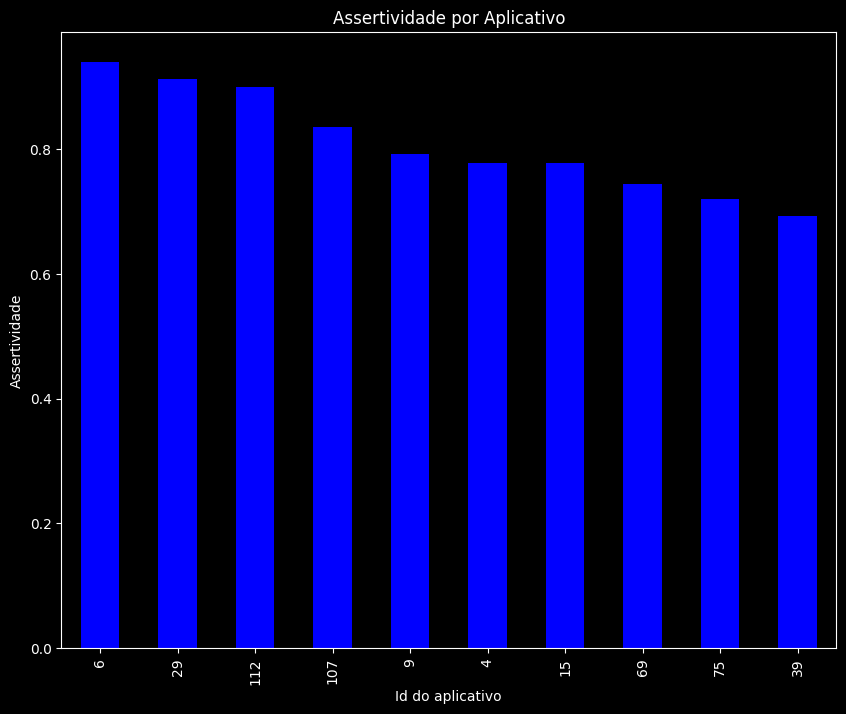

In [161]:
# Assertividade por App

fig = plt.figure(figsize=(10, 8))
assertividade_id_cov['assertividade'].head(10).plot(kind='bar', color = 'blue')
plt.title('Assertividade por Aplicativo')
plt.xlabel('Id do aplicativo')
plt.ylabel('Assertividade')
plt.plot()

In [42]:
print(f'{round(np.mean(assertividade_id_cov["assertividade"])*100)}% de Assertividade Média')

60% de Assertividade Média


Cobertura

In [43]:
cobertura_id_cov = df_covisitation_recommendation.groupby('id').mean('cobertura').reset_index()[['id', 'cobertura']].sort_values('cobertura', ascending = False).set_index('id')
cobertura_id_cov.head()

,cobertura
id,
49,0.956522
112,0.909091
62,0.875000
107,0.870370
80,0.868852


[]

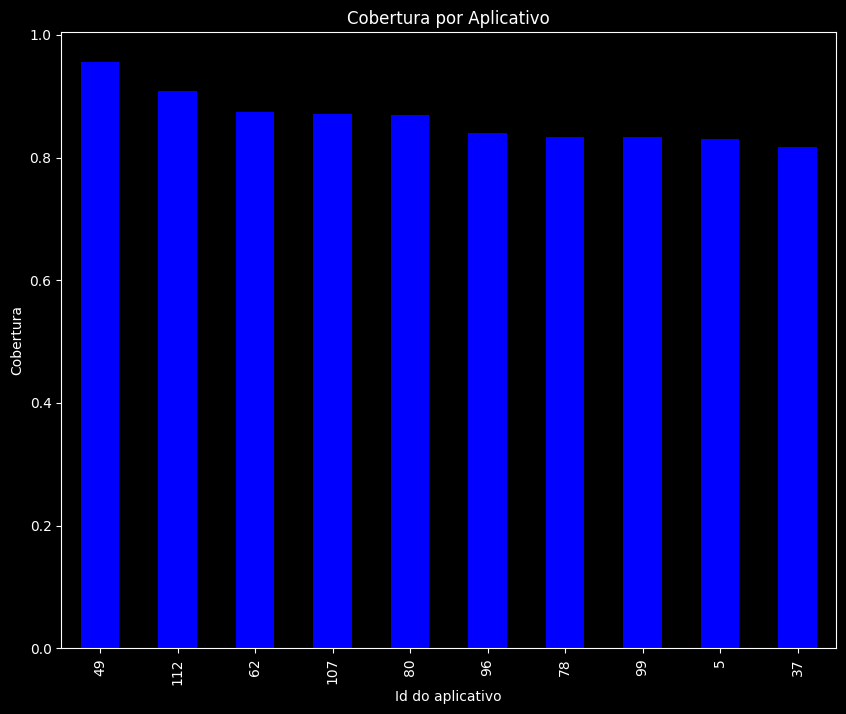

In [160]:
# Cobertura por App

fig = plt.figure(figsize=(10, 8))
cobertura_id_cov['cobertura'].head(10).plot(kind='bar', color = 'blue')
plt.title('Cobertura por Aplicativo')
plt.xlabel('Id do aplicativo')
plt.ylabel('Cobertura')
plt.plot()

In [45]:
print(f'{round(np.mean(cobertura_id["cobertura"])*100)}% de Cobertura Média')

12% de Cobertura Média


## Combinação 2 a 2 

In [252]:
df_combination_recommendation = pd.DataFrame()
app = base['id_aplicativo'].unique()
app.sort()

# Rodar o modelo para todos os app do dataset
for i in app:
    if base.loc[base['id_aplicativo'] == i].shape[0] >= 500:
        df = base.loc[base['id_aplicativo'] == i]
        df = df[['id_aplicativo', 'id_compra', 'Date', 'user_id', 'quantidade', 'item_id']]
        NumProduto, totalFreq, FreqCompra, dfProduto, df_combination, user_list = base_tratatives(df)

        df_test_combination = test_df(df_combination, user_list)
        df_train_combination = df_combination.drop(df_test_combination.index ,axis = 0)
        item_seed_df = item_seed(df_train_combination, user_list)
        user_list = df_train_combination['user_id'].unique()
        df_seed = item_seed(df_train_combination, user_list)

        item_combinations = combinacao(df_train_combination)

        df_combination_recommendation_temp = recommendation_permutation(df_seed, item_combinations)

        df_combination_recommendation_temp = explosion(df_combination_recommendation_temp, df_test_combination)
        df_combination_recommendation_temp['id'] = i
        df_combination_recommendation_temp['assertividade'] = df_combination_recommendation_temp['true'].sum()/df_combination_recommendation_temp['true'].count()
        flat_recommendations = [item for sublist in df_combination_recommendation_temp['recommendation'] for item in sublist]
        df_combination_recommendation_temp['cobertura'] = len(set(flat_recommendations)) / len(pd.DataFrame(dfProduto['item_id'].unique()))

        df_combination_recommendation = df_combination_recommendation.append(df_combination_recommendation_temp)

In [253]:
assertividade_id_c22 = df_combination_recommendation.groupby('id').mean('assertividade').reset_index()[['id', 'assertividade']].sort_values('assertividade', ascending = False).set_index('id')
assertividade_id_c22.head()

,assertividade
id,
6,0.963636
29,0.900398
112,0.816754
107,0.777778
4,0.755694


[]

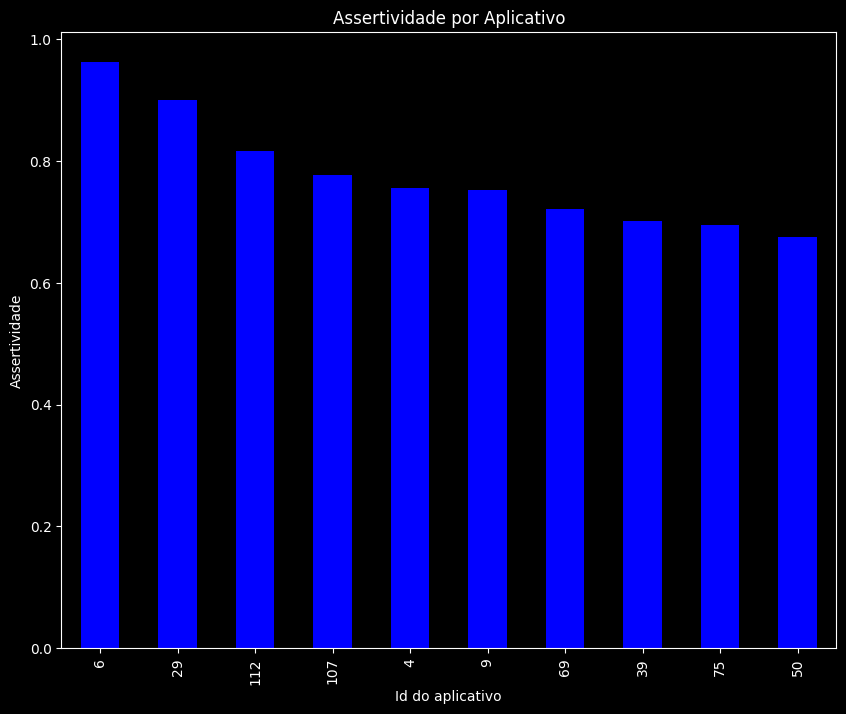

In [254]:
# Assertividade por App

fig = plt.figure(figsize=(10, 8))
assertividade_id_c22['assertividade'].head(10).plot(kind='bar', color = 'blue')
plt.title('Assertividade por Aplicativo')
plt.xlabel('Id do aplicativo')
plt.ylabel('Assertividade')
plt.plot()

In [255]:
print(f'{round(np.mean(assertividade_id_c22["assertividade"])*100)}% de Assertividade Média')

61% de Assertividade Média


Cobertura

In [261]:
cobertura_id_c22 = df_combination_recommendation.groupby('id').mean('cobertura').reset_index()[['id', 'cobertura']].sort_values('cobertura', ascending = False).set_index('id')
cobertura_id_c22.head()

,cobertura
id,
112,0.909091
49,0.869565
99,0.771605
62,0.750000
107,0.740741


[]

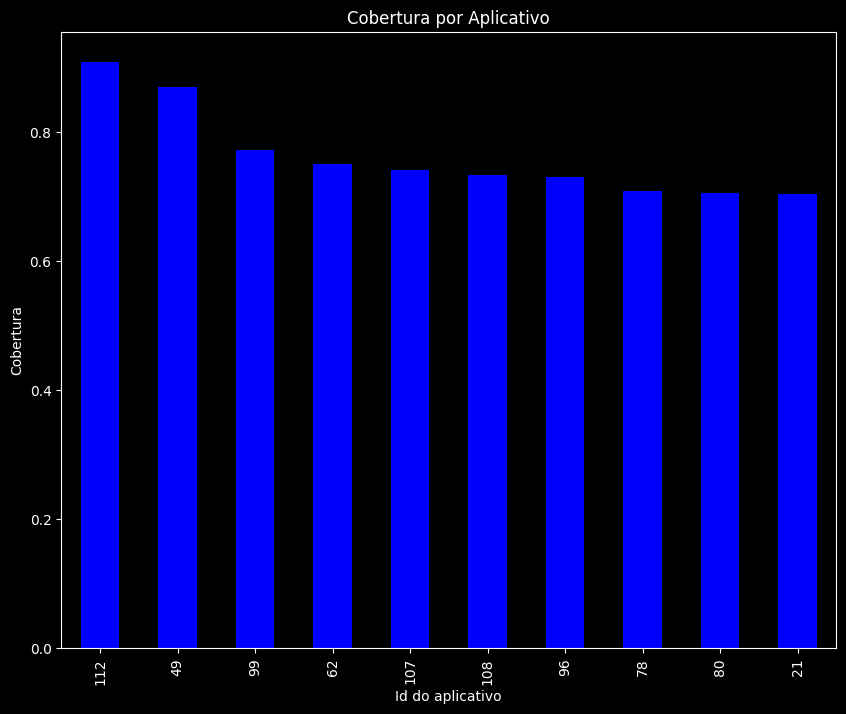

In [262]:
# Cobertura por App

fig = plt.figure(figsize=(10, 8))
cobertura_id_c22['cobertura'].head(10).plot(kind='bar', color = 'blue')
plt.title('Cobertura por Aplicativo')
plt.xlabel('Id do aplicativo')
plt.ylabel('Cobertura')
plt.plot()

In [263]:
print(f'{round(np.mean(cobertura_id["cobertura"])*100)}% de Cobertura Média')

12% de Cobertura Média


## TOP N

In [46]:
df_top_recommendation_app = pd.DataFrame()
app = base['id_aplicativo'].unique()
app.sort()

for i in app:
    if base.loc[base['id_aplicativo'] == i].shape[0] >= 500:
        df = base.loc[base['id_aplicativo'] == i]
        df_top_consumptions = recommend_top_n_consumptions(df, n = 10)
        
        NumProduto, totalFreq, FreqCompra, dfProduto, df_covisitation, user_list = base_tratatives(df)

        df_test_covisitation = test_df(df_covisitation, user_list)
        df_train_covisitation = df_covisitation.drop(df_test_covisitation.index ,axis = 0)

        user_list = df_train_covisitation['user_id'].unique()
        df_seed = item_seed(df_train_covisitation, user_list)
        
        df_top_recommendations = recommendation_top(df_seed, df_top_consumptions)

        df_top_recommendation = df_top_recommendations.groupby('user_id').agg({'recommendation': list}).reset_index(drop=False)
        df_top_recommendation = df_top_recommendation.merge(df_test_covisitation[['user_id', 'item_id']], on = 'user_id', how = 'left')
        explode = df_top_recommendation.explode('recommendation').reset_index(drop = True)
        
        explode['true'] = 0
        for index in explode.index:
            if explode['recommendation'][index] == explode['item_id'][index]:
                explode['true'][index] = 1
        
        df_top_recommendation_temp = explode.groupby(['user_id', 'item_id']).agg({'recommendation': list, 'true': sum}).reset_index(drop=False)
        df_top_recommendation_temp['id'] = i
        df_top_recommendation_temp['assertividade'] = df_top_recommendation_temp['true'].sum()/df_top_recommendation_temp['true'].count()
        flat_recommendations = [item for sublist in df_top_recommendation_temp['recommendation'] for item in sublist]
        df_top_recommendation_temp['cobertura'] = len(set(flat_recommendations)) / len(pd.DataFrame(dfProduto['item_id'].unique()))

        df_top_recommendation_app = df_top_recommendation_app.append(df_top_recommendation_temp)

In [47]:
# df_top_recommendation_app.to_excel('topn_todos_app.xlsx')

In [48]:
assertividade_id_top = df_top_recommendation_app.groupby('id').mean('assertividade').reset_index()[['id', 'assertividade']].sort_values('assertividade', ascending = False).set_index('id')
assertividade_id_top.head()

,assertividade
id,
6,0.983051
29,0.895759
112,0.874346
15,0.814815
75,0.720588


In [152]:
plt.style.use('dark_background')

[]

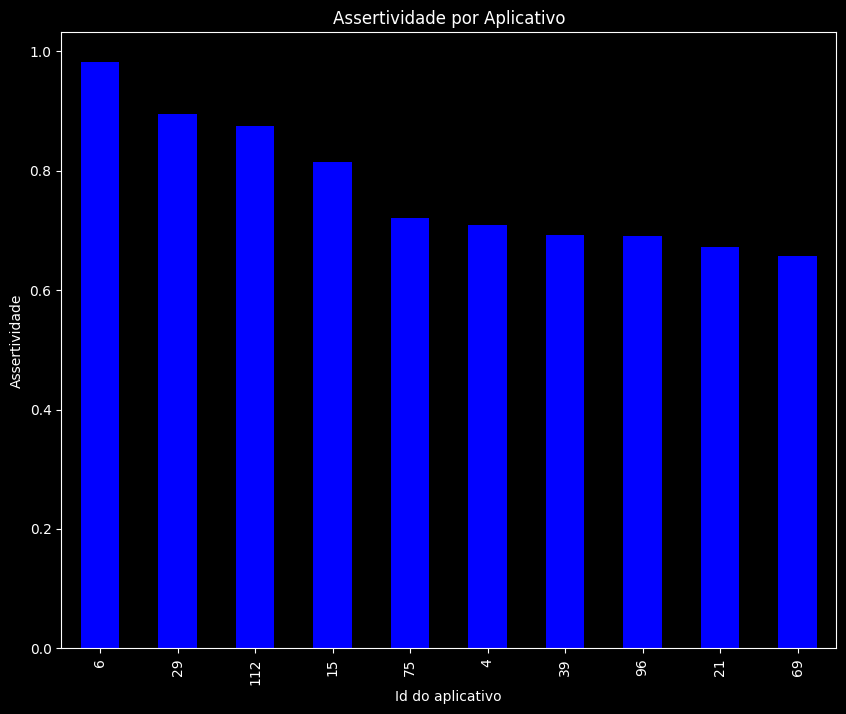

In [154]:
# Assertividade por App

fig = plt.figure(figsize=(10, 8))
assertividade_id_top['assertividade'].head(10).plot(kind='bar', color = 'blue')
plt.title('Assertividade por Aplicativo')
plt.xlabel('Id do aplicativo')
plt.ylabel('Assertividade')
plt.plot()

In [50]:
print(f'{round(np.mean(assertividade_id_top["assertividade"])*100)}% de Assertividade Média')

56% de Assertividade Média


Cobertura

In [51]:
cobertura_id_top = df_top_recommendation_app.groupby('id').mean('cobertura').reset_index()[['id', 'cobertura']].sort_values('cobertura', ascending = False).set_index('id')
cobertura_id_top.head()

,cobertura
id,
112,0.454545
50,0.263158
39,0.232558
15,0.227273
78,0.208333


[]

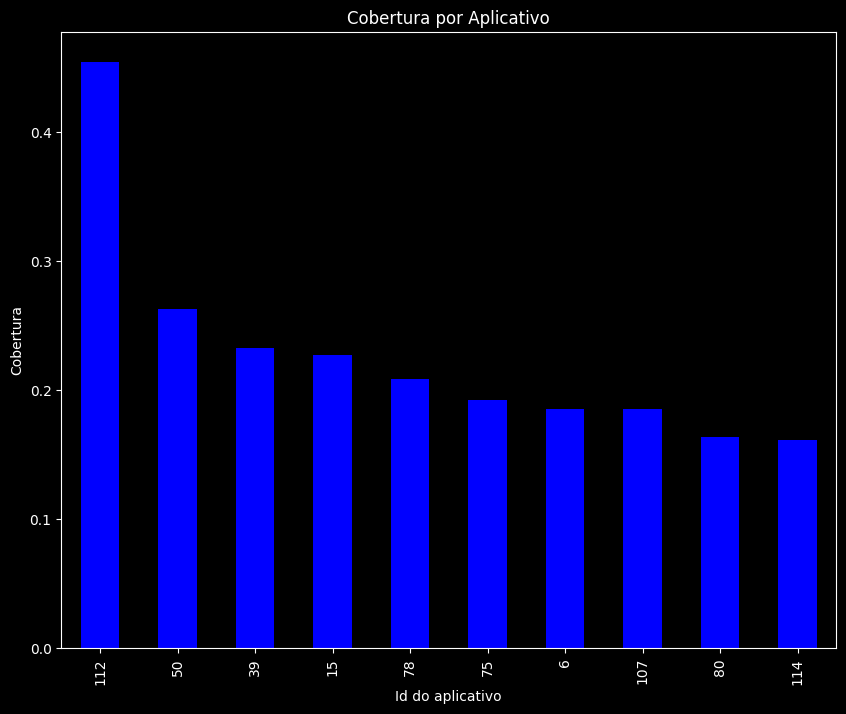

In [156]:
# Cobertura por App

fig = plt.figure(figsize=(10, 8))
cobertura_id_top['cobertura'].head(10).plot(kind='bar', color = 'blue')
plt.title('Cobertura por Aplicativo')
plt.xlabel('Id do aplicativo')
plt.ylabel('Cobertura')
plt.plot()

In [53]:
print(f'{round(np.mean(cobertura_id["cobertura"])*100)}% de Cobertura Média')

12% de Cobertura Média


## Quantidade de Itens diferentes por app

In [54]:
lista_app = base['id_aplicativo'].unique()
quantidade_itens = pd.DataFrame()
quantidade_itens['id_aplicativo'] = lista_app
df_temp = pd.DataFrame()
quantidade = list()

for i in lista_app:
    temp = base.query('id_aplicativo == @i')
    quantidade.append(temp['item_id'].nunique())

quantidade_itens['quantidade_itens'] = quantidade
quantidade_itens = quantidade_itens.sort_values('quantidade_itens', ascending= False).set_index('id_aplicativo')

In [55]:
quantidade_itens.head()

,quantidade_itens
id_aplicativo,
5,502
116,284
94,277
82,261
106,257


[]

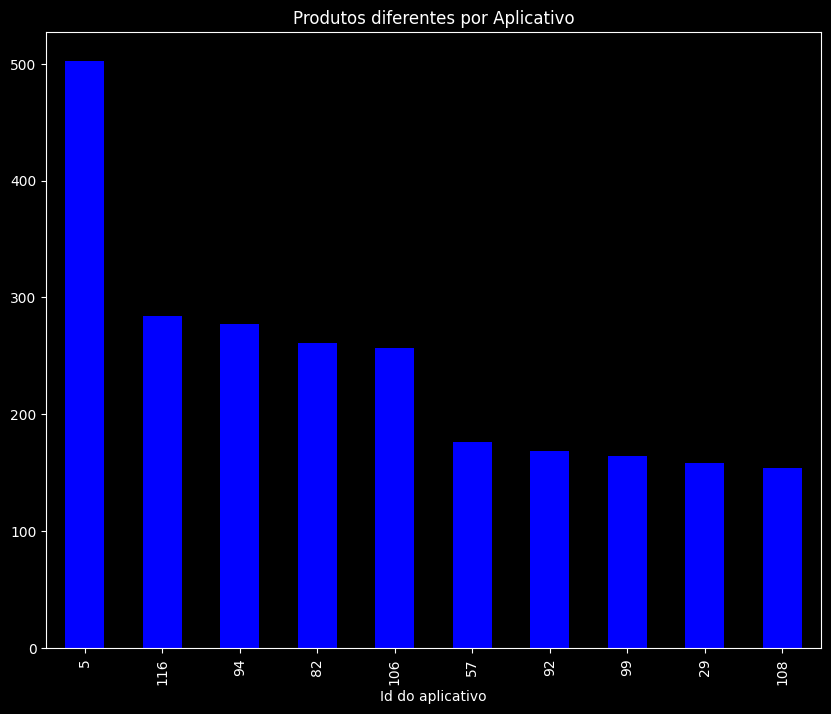

In [158]:
# Número de itens diferentes por App

fig = plt.figure(figsize=(10, 8))
quantidade_itens['quantidade_itens'].head(10).plot(kind='bar', color = 'blue')
plt.title('Produtos diferentes por Aplicativo')
plt.xlabel('Id do aplicativo')
plt.plot()

## Comparação

In [272]:
dict = {'Modelo': ['Top N', 'Covisitation', 'Combinação 2 a 2'], 'Assertividade (%)': [56, 60, 61], 'Cobertura (%)':[12, 77, 12]}
metricas_finais = pd.DataFrame(dict).set_index('Modelo')
metricas_finais

,Assertividade (%),Cobertura (%)
Modelo,,
Top N,56,12
Covisitation,60,77
Combinação 2 a 2,61,12
